In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
#from matplotlib import rc
import pandas as pd
import importlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

#rc('font',**{'family':'serif'})
#rc('text', usetex=True)

np.random.seed(4)

In [42]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0 = Masses['A'].to_numpy()
Z0 = Masses['Z'].to_numpy()
N0 = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies0 = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc0 = Masses['E_unc'].to_numpy()


In [173]:
# select spaced energies over interval

start = 15
step = 5
stop = 258

Energies = Energies0[start:stop:step]
A = A0[start:stop:step]
Z = Z0[start:stop:step]
N = N0[start:stop:step]

print(len(A))

49


In [174]:
ndim = 6

In [175]:
# define parameter space


theta_0_bound = np.array([4, 5]).reshape(1,-1)
theta_1_bound = np.array([-0.25, -0.15]).reshape(1,-1)
theta_2_bound = np.array([0.8, 1.1]).reshape(1,-1)
theta_3_bound = np.array([0.006, 0.009]).reshape(1,-1) # keep
theta_4_bound = np.array([0.25, 0.4]).reshape(1,-1)
theta_5_bound = np.array([-0.1, 0.1]).reshape(1,-1)


parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound, theta_5_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)



theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[3,0], parameter_bounds[3,1], 100)
theta_4_vals = np.linspace(parameter_bounds[4,0], parameter_bounds[4,1], 100)
theta_5_vals = np.linspace(parameter_bounds[5,0], parameter_bounds[5,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1), theta_4_vals.reshape(1,-1), theta_5_vals.reshape(1,-1)), axis=0)


In [176]:
def LiquidDropModel(A, Z, N, **parameters):
    
    indep_var = [1, A, (A**(2.0/3.0)), Z*(Z-1)*(A**(-1.0/3.0)), \
                 ((N-Z)**2)/A, ( (-1)**Z + (-1)**N )*(2*A**(-0.5))]
    
    E_B = 0
    
    for i in range(len(parameters)):
        E_B += parameters[i]*indep_var[i]
    
    return E_B

In [177]:
indep_var = [1, A, (A**(2.0/3.0)), Z*(Z-1)*(A**(-1.0/3.0)), \
                 ((N-Z)**2)/A, ( (-1)**Z + (-1)**N )*(2*A**(-0.5))]

def design_matrix(ndim):
    # design matrix X
    X = np.zeros((len(A),ndim))
    for i in range(ndim):
        X[:,i] = indep_var[i]
    return X



X1 = np.zeros((len(A),ndim))
for i in range(ndim):
    X1[:,0] = np.ones_like(A)
    X1[:,1] = A
    X1[:,2] = A**(2.0/3.0)
    

X2 = np.zeros((len(A),ndim))
for i in range(ndim):
    X2[:,1] = A
    X2[:,2] = A**(2.0/3.0)
    X2[:,3] = Z*(Z-1) * A**(-1.0/3.0)



In [178]:
clf_6d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(6), Energies)

clf_3d1 = skl.LinearRegression(fit_intercept=False).fit(X1, Energies)

clf_3d2 = skl.LinearRegression(fit_intercept=False).fit(X2, Energies)

print(clf_6d.coef_)

preds_6d = clf_6d.predict(design_matrix(6))
preds_3d1 = clf_3d1.predict(X1)
preds_3d2 = clf_3d2.predict(X2)

err = np.sum(np.square(Energies-preds_6d))


#pred_sigma = np.sqrt(np.var(err))
pred_sigma = np.sqrt(err / (len(Energies) - ndim - 1))

print(pred_sigma)

[ 5.96815939e+00 -1.33398333e-01  6.37238988e-01  4.79057879e-03
  1.98282462e-01  5.86412944e-02]
0.03196587996501934


Text(0.5, 1.0, '24 Output Predictions, 6D Model (aV,aS,aC)')

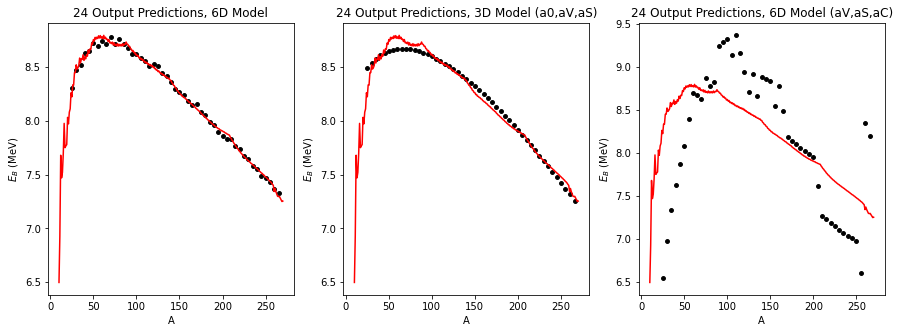

In [179]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.scatter(A, preds_6d, color='black', s=15)
ax1.plot(A0, Energies0, color='red')
ax1.set_xlabel('A')
ax1.set_ylabel(r'$E_{B}$ (MeV)')
ax1.set_title('24 Output Predictions, 6D Model')

ax2.scatter(A, preds_3d1, color='black', s=15)
ax2.plot(A0, Energies0, color='red')
ax2.set_xlabel('A')
ax2.set_ylabel(r'$E_{B}$ (MeV)')
ax2.set_title('24 Output Predictions, 3D Model (a0,aV,aS)')

ax3.scatter(A, preds_3d2, color='black', s=15)
ax3.plot(A0, Energies0, color='red')
ax3.set_xlabel('A')
ax3.set_ylabel(r'$E_{B}$ (MeV)')
ax3.set_title('24 Output Predictions, 6D Model (aV,aS,aC)')


In [141]:
# ***** mean of unc?? corresponds to each output ***********
variance = np.mean(Energies_unc)**2 + pred_sigma**2
print(variance)

0.0006918930119554812


In [142]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [143]:
A1 = A_matrix(X, variance)
b1 = Energies / np.sqrt(variance)

In [144]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [145]:
theta = solve_theta(A1, b1)
print(theta)

[ 1.15602956e+01 -4.78145124e-03 -5.30051101e-02 -2.52866848e-05
  6.66870215e-03 -3.30207448e+00]


In [146]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [29]:
H1 = H_matrix(A1)
cov_matrix = covariance(X, variance)

In [30]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * np.sqrt(5.991) * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [31]:
def plot_ellipses(fig, parameter_bounds, true_parameters, H, theta_best, theta_vals, color):
    theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{A}$', r'$a_{P}$']
    N = len(theta_best)
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                ax_right = ax.twinx()
                ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                if i == 3:
                    ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                   str(round(np.sqrt(H[i,i]),4)), fontsize=14)
                else:
                    ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                       str(round(np.sqrt(H[i,i]),3)), fontsize=14)
                
            elif i < j:
                
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                #ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                #zax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
            else:
                ax.axis('off')
                
    plt.tight_layout()

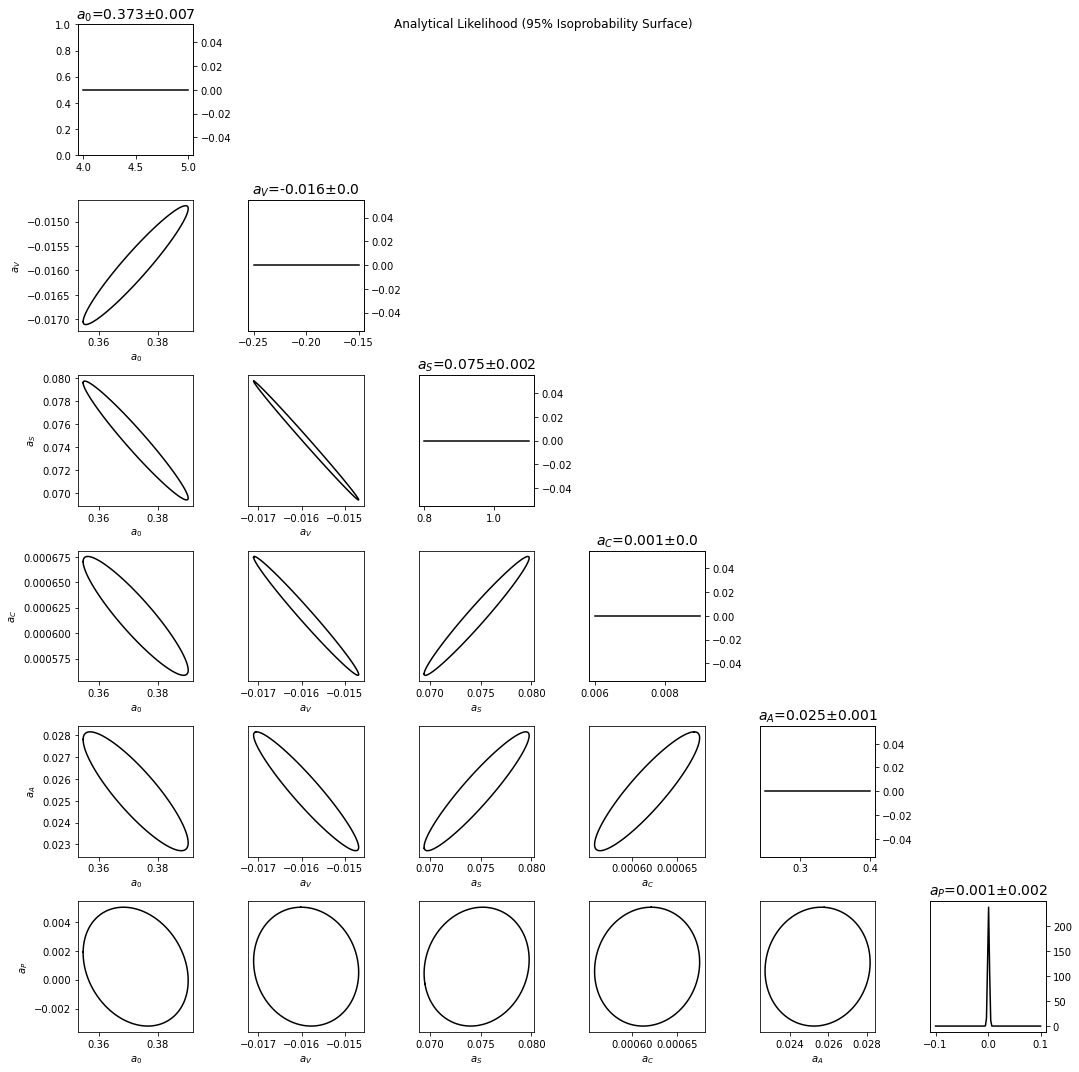

In [32]:
color_list = ['black', 'plum', 'mediumaquamarine', 'red']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(15,15))

plot_ellipses(fig, parameter_bounds, theta, H1, theta, theta_vals, color_list[0])
fig.suptitle(r'Analytical Likelihood (95% Isoprobability Surface)')
plt.savefig('figures/LD_analytical.png', bbox_inches='tight', facecolor='white', transparent=False)

In [33]:
file2 = open("data/LD_analytic_mean.txt", "w")

np.savetxt(file2, theta)
    
file2.close()

file1 = open("data/LD_analytic_cov.txt", "w")

for i in range(H1.shape[0]):
    np.savetxt(file1, H1[i])
    
file1.close()

print(H1)

[[ 5.32791733e-05  3.45446080e-06 -1.50041370e-05 -1.59042943e-07
  -7.05089580e-06 -2.84583858e-06]
 [ 3.45446080e-06  2.48047741e-07 -1.05300273e-06 -1.17247958e-08
  -5.22651174e-07 -7.98305626e-08]
 [-1.50041370e-05 -1.05300273e-06  4.49611036e-06  4.93646955e-08
   2.20669469e-06  4.08718992e-07]
 [-1.59042943e-07 -1.17247958e-08  4.93646955e-08  5.69753309e-10
   2.38400535e-08  3.10918679e-09]
 [-7.05089580e-06 -5.22651174e-07  2.20669469e-06  2.38400535e-08
   1.23880649e-06  1.32285536e-07]
 [-2.84583858e-06 -7.98305626e-08  4.08718992e-07  3.10918679e-09
   1.32285536e-07  2.82156256e-06]]
